In [2]:
!python3 -m pip -q install pandas
!python3 -m pip -q install matplotlib
!python3 -m pip -q install scikit-learn
!python3 -m pip -q install statsmodels
!python3 -m pip -q install tqdm

# Data extraction

In [ ]:
import os
ss = f"grep -e '.*_WAS_.*_RZ.*Wasserverbrauch' energy_data.sql > water.txt"
os.system(ss)

In [ ]:
file = open('water.txt', 'r')
lines = file.readlines()

for line in lines:
    id = line.split()[0]
    ss = "tail -n +380140044 energy_data.sql | head -n 24179009770 | grep -w '^" + id + "' > rawvalues/" + id + ".txt"
    os.system(ss)

# Create the Dataframe

In [3]:
import os
import pandas as pd
from os.path import isfile, join
from tqdm.auto import tqdm, trange

df_list = []
file_path = 'rawvalues/'
files = os.listdir(file_path)

for f in tqdm(files):
    if isfile(join(file_path, f)):
        df = pd.read_csv(file_path + f, sep='\t', index_col='date', names=['ID', 'date', 'value'])
        df = df[~df.index.duplicated(keep=False)]
        df.dropna(inplace = True)
        df = df[df['value'].values != 0.0]
        df.sort_values(by=['date', 'value'], ascending=True, inplace=True)
        df_list.append(df)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


# Test-Train split

In [4]:
TRAIN_SIZE = 0.9

df_train = df_list[:int(len(df_list)*TRAIN_SIZE)]
df_test = df_list[int(len(df_list)*TRAIN_SIZE):]

# ARIMA

## Model

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class ARIMA(object):
    def __init__(self):
        pass

    def AR(self, df, p, val_col='value', out_pred_col='predicted_value', predict=0, train_size=0.8):
        _df = df.copy()

        # Generating the lagged n terms
        for i in range(1, p + 1):
            _df[f'shifted_values_{i}'] = _df[val_col].shift(i)
        _df.dropna(inplace=True)

        _train_size = int(train_size * _df.shape[0])

        # Breaking data set into test and training
        _df_train = pd.DataFrame(_df[:_train_size])
        _df_test = pd.DataFrame(_df[_train_size:])

        # X contains the lagged values ,hence we skip the first column
        x_train = _df_train.iloc[:, 1:].values.reshape(-1, p)
        # Y contains the value, it is the first column
        y_train = _df_train.iloc[:, 0].values.reshape(-1, 1)
        
        # Same thing with the test set
        x_test = _df_test.iloc[:, 1:].values.reshape(-1, p)
        y_test = _df_test.iloc[:, 0].values.reshape(-1, 1)

        # Running linear regression to generate the coefficents of lagged terms
        lr = LinearRegression()
        lr.fit(x_train, y_train)

        theta  = lr.coef_.T
        intercept = lr.intercept_

        if predict == 1 and hasattr(self, 'ar_theta_mean') and hasattr(self, 'ar_intercept_mean'):
            theta = (theta + self.ar_theta_mean) / 2
            intercept = (intercept + self.ar_intercept_mean) / 2
        elif predict == 2 and hasattr(self, 'ma_theta_mean') and hasattr(self, 'ma_intercept_mean'):
            theta = (theta + self.ma_theta_mean) / 2
            intercept = (intercept + self.ma_intercept_mean) / 2
        
        _df_train[out_pred_col] = x_train.dot(theta) + intercept
        _df_test[out_pred_col] = x_test.dot(theta) + intercept

        rmse = np.sqrt(mean_squared_error(y_test, _df_test[out_pred_col]))

        new_df = pd.concat([_df_train, _df_test])[[val_col, out_pred_col]]
        return new_df, theta, intercept, rmse

    def I(self, df, d, val_col='value', fn=None):
        _df = df.copy()
        
        if fn is not None:
            _df = pd.DataFrame(fn(_df[val_col])).dropna()
        else:
            for i in range(d):
                _df = pd.DataFrame(_df[val_col].diff()).dropna()

        _df_nz = _df[_df['value'] != 0]
        _df_z = _df[_df['value'] == 0]
                
        return _df_nz, _df_z

    def MA(self, df, q, val_col='value', in_pred_col='predicted_value', out_pred_col='ma_predicted_value', predict=0, train_size=0.8):
        _df = df.copy()
        _df['residual'] = _df[val_col] - _df[in_pred_col]
        
        return self.AR(_df[['residual']], q, 'residual', out_pred_col, predict, train_size)

    def fit(self, df_list, p, d, q, val_col, train_size, stationary_fn=None):
        self.p = p
        self.d = d
        self.q = q
        
        df_list_len = [len(df) for df in df_list]
        df_list_len_norm = (df_list_len - np.min(df_list_len)) / (np.max(df_list_len) - np.min(df_list_len))
        
        df_dict = {}
        
        ar_theta_list = []
        ar_intercept_list = []
        
        ma_theta_list = []
        ma_intercept_list = []
        
        for idx, df in enumerate(df_list):
            _df = df.copy()
            factor = df_list_len_norm[idx]
            
            id = _df['ID'].values[0]
            df_dict[id] = {}
            stationary_df = None
            
            stationary_df_nz, stationary_df_z = self.I(_df, d, val_col, stationary_fn)
            ar_out_df, ar_theta, ar_intercept, ar_rmse = self.AR(stationary_df_nz, p, val_col, 'ar_predicted_value', 0, train_size)
            ma_out_df, ma_theta, ma_intercept, ma_rmse = self.MA(ar_out_df, q, val_col, 'ar_predicted_value', 'ma_predicted_value', 0, train_size)
            stationary_df_nz['prediction'] = ar_out_df['ar_predicted_value'] + ma_out_df['ma_predicted_value']
            stationary_df = pd.concat([stationary_df_nz, stationary_df_z])
            stationary_df.fillna(0, inplace=True)
            # print(f'fit - orig: {len(_df)}, nz: {len(stationary_df_nz)}, z: {len(stationary_df_z)}, concat: {len(stationary_df)}')

            ar_theta_list.append(ar_theta * factor)
            ar_intercept_list.append(ar_intercept * factor)
            
            ma_theta_list.append(ma_theta * factor)
            ma_intercept_list.append(ma_intercept * factor)

            df_dict[id]["df"] = stationary_df
            df_dict[id]["ar_theta"] = ar_theta
            df_dict[id]["ar_intercept"] = ar_intercept
            df_dict[id]["ma_theta"] = ma_theta
            df_dict[id]["ma_intercept"] = ma_intercept

        self.ar_theta_mean = np.mean(ar_theta_list)
        self.ar_intercept_mean = np.mean(ar_intercept_list)
        
        self.ma_theta_mean = np.mean(ma_theta_list)
        self.ma_intercept_mean = np.mean(ma_intercept_list)
            
        return df_dict, self.ar_theta_mean, self.ar_intercept_mean, ar_rmse, self.ma_theta_mean, self.ma_intercept_mean, ma_rmse

    def predict(self, df, p, d, q, val_col='value', stationary_fn=None):
        _df = df.copy()
        stationary_df_nz, stationary_df_z = self.I(_df, d, val_col, stationary_fn)
        ar_out_df, ar_theta, ar_intercept, ar_rmse = self.AR(stationary_df_nz, p, val_col, 'ar_predicted_value', 1)
        ma_out_df, ma_theta, ma_intercept, ma_rmse = self.MA(ar_out_df, q, val_col, 'ar_predicted_value', 'ma_predicted_value', 2)
        stationary_df_nz['prediction'] = ar_out_df['ar_predicted_value'] + ma_out_df['ma_predicted_value']
        stationary_df = pd.concat([stationary_df_nz, stationary_df_z])
        stationary_df.fillna(0, inplace=True)
        # print(f'predict - orig: {len(_df)}, nz: {len(stationary_df_nz)}, z: {len(stationary_df_z)}, concat: {len(stationary_df)}')

        return stationary_df, ar_rmse, ma_rmse

# Train model

## Helper functions

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_check(data):
    result = adfuller(data)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print(f'{label} : {str(value)}')
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [6]:
stationary_fn = lambda x: x.diff()

def reverse_stationary_fn(ori_x, new_x):
    x = new_x.copy()
    x += ori_x.shift(1)
    return x

## Training

In [6]:
min_ar_rmse = min_ma_rmse = float('inf')
best_p, best_q = 2, 1

arima = ARIMA()

In [5]:
for i in range(1, 6):
    for j in range(1, 6):
        print(f'order({i}, 1, {j})')
        df_dict, ar_theta_mean, ar_intercept_mean, ar_rmse, ma_theta_mean, ma_intercept_mean, ma_rmse = arima.fit(df_train, i, 1, j, 'value', TRAIN_SIZE)

        if ar_rmse < min_ar_rmse:
            min_ar_rmse = ar_rmse
            best_p = i

        if ma_rmse < min_ma_rmse:
            min_ma_rmse = ma_rmse
            best_q = j

print(ar_theta_mean, ar_intercept_mean, ar_rmse, ma_theta_mean, ma_intercept_mean, ma_rmse, sep='\n\n')

order(1, 1, 1)
order(1, 1, 2)
order(1, 1, 3)
order(1, 1, 4)
order(1, 1, 5)
order(2, 1, 1)
order(2, 1, 2)
order(2, 1, 3)
order(2, 1, 4)
order(2, 1, 5)
order(3, 1, 1)
order(3, 1, 2)
order(3, 1, 3)
order(3, 1, 4)
order(3, 1, 5)
order(4, 1, 1)
order(4, 1, 2)
order(4, 1, 3)
order(4, 1, 4)
order(4, 1, 5)
order(5, 1, 1)
order(5, 1, 2)
order(5, 1, 3)
order(5, 1, 4)
order(5, 1, 5)
0.02676028388740366

0.012270044695569016

0.013104224770851453

-0.003780171111711005

1.02938863486654e-06

0.013103644077058925


In [6]:
print(f'Min RMSE of AR model: {min_ar_rmse} | Best P: {best_p}')
print(f'Min RMSE of MA model: {min_ma_rmse} | Best Q: {best_q}')

Min RMSE of AR model: 0.01308899657652098 | Best P: 2
Min RMSE of MA model: 0.013087768526248227 | Best Q: 1


# Evaluation

In [8]:
arima = ARIMA()
df_dict, ar_theta_mean, ar_intercept_mean, ar_rmse, ma_theta_mean, ma_intercept_mean, ma_rmse = arima.fit(df_train, best_p, 1, best_q, 'value', TRAIN_SIZE)

In [11]:
predict_with_train = []
predict_with_train_ci = []
percentile = 5

for df in df_test:
    predict_df, ar_rmse, ma_rmse = arima.predict(df, best_p, 1, best_q, 'value')
    predict_df_nz = predict_df[predict_df['value'] != 0]
    
    predict_df_nz['residuals'] = predict_df_nz['value'] - predict_df_nz['prediction']
    RMSFE = np.sqrt(sum([x**2 for x in predict_df_nz['residuals']]) / len(predict_df_nz['residuals']))
    band_size = percentile * RMSFE
    
    predict_with_train.append(predict_df_nz)
    predict_with_train_ci.append(band_size)

/tmp/ipykernel_4802/2162498584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df_nz['residuals'] = predict_df_nz['value'] - predict_df_nz['prediction']
/tmp/ipykernel_4802/2162498584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df_nz['residuals'] = predict_df_nz['value'] - predict_df_nz['prediction']
/tmp/ipykernel_4802/2162498584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

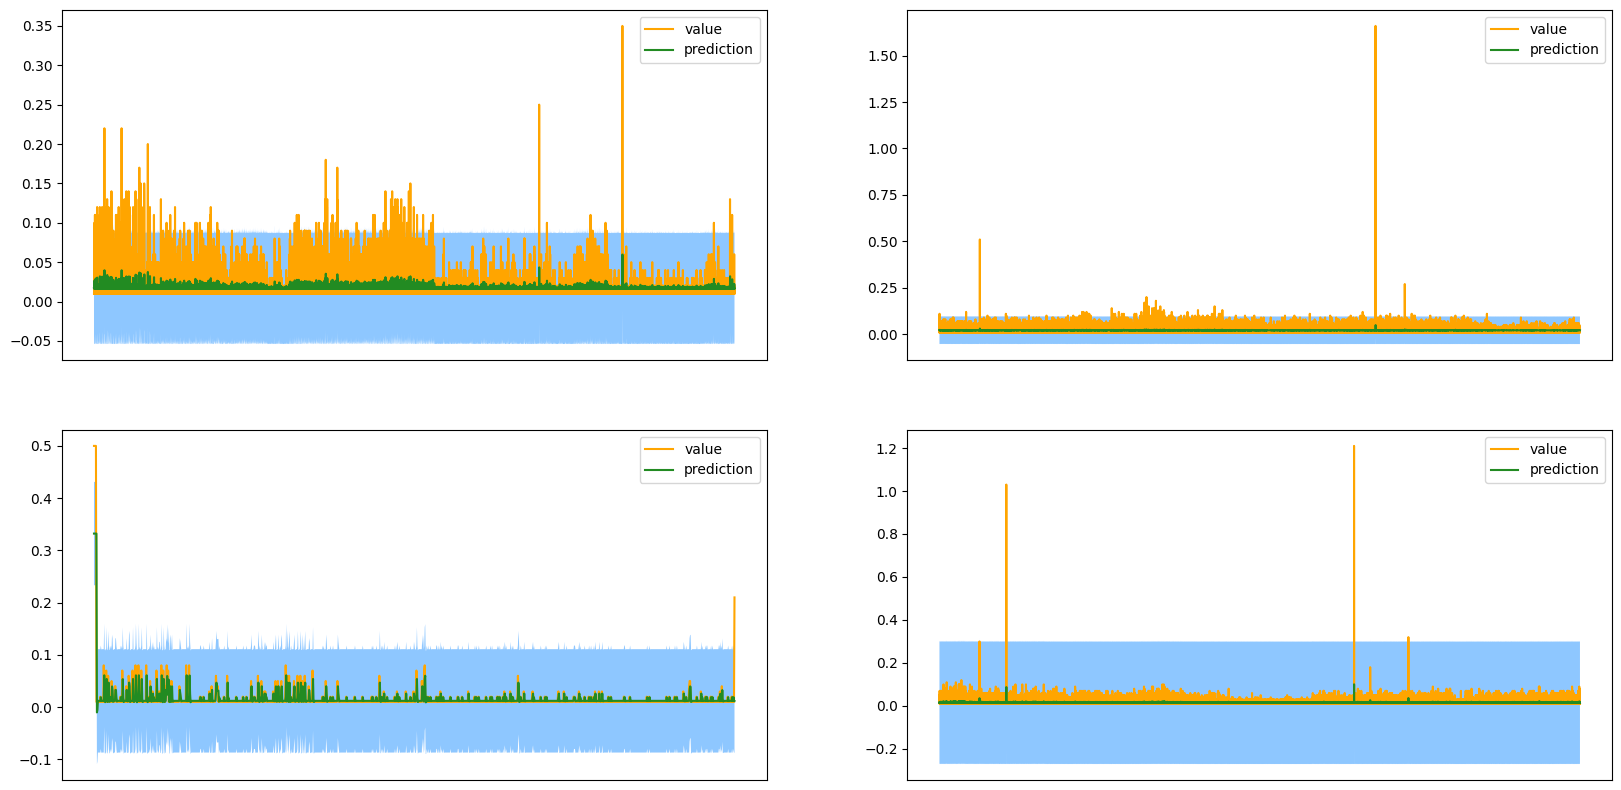

In [10]:
fig = plt.figure(1, figsize=(20,10))
f, t = 10,11000

for idx, df in enumerate(predict_with_train):
    axs = fig.add_subplot(2, 2, idx+1)
    axs.get_xaxis().set_visible(False)
    df[f:].plot(y='value', ax=axs, alpha=1, color='orange')
    df[f:].plot(y='prediction', ax=axs, alpha=1, color='forestgreen')
    axs.fill_between(df[f:].index, (df[f:]['prediction']-predict_with_train_ci[idx]), (df[f:]['prediction']+predict_with_train_ci[idx]), color='dodgerblue', edgecolor='none', alpha=0.5)

plt.savefig('model_evaluation.png')